# LAB 05 Assigment

Dominik Breksa (dominikbreksa@student.agh.edu.pl)

In [2]:
import numpy as np;import matplotlib.pyplot as plt;from open_atmos_jupyter_utils import show_plot;from functools import partial;plt.rcParams['axes.grid'] = True

In [3]:
class Shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i):
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i):
        return slice(i.start - self.sub, i.stop - self.sub)

one = Shift(add=1, sub=1)
hlf = Shift(add=0, sub=1)

def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

def upwind(psi, i, C):
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], C[i + hlf]) -
        F(psi[i - one], psi[i      ], C[i - hlf])
    )

In [4]:
def solve_upwind(*, nt: int, C: np.ndarray, psi: np.ndarray):
    assert np.all(np.abs(C) < 1), 'All the C must be less than zero'

    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)

    return psi

def psi_0(x: np.ndarray, x0: float=0, a: float=1, sigma: float=20):
    return a * np.exp(-(x-x0) ** 2 / 2 / sigma ** 2)

def plot(x, **kwargs):
    for label, data in kwargs.items():
        plt.step(x, data, label=label, where='mid')
    plt.legend()
    plt.grid()
    show_plot()

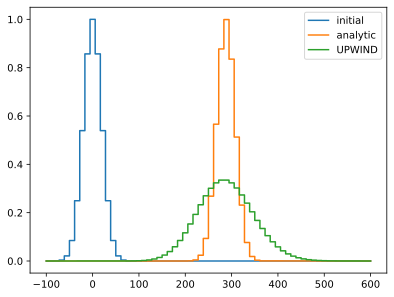

In [5]:
U = 4
T_MAX = 72

nx = 64
nt = 1600
dt = T_MAX / nt
x, dx = np.linspace(-100, 600, nx, retstep=True)

plot(
    x=x,
    initial=psi_0(x),
    analytic=psi_0(x - U * T_MAX),
    UPWIND=solve_upwind(nt=nt, C=np.full(nx - 1, U * dt / dx), psi=psi_0(x))
)

In [6]:
def corrective_c(c: np.ndarray, i: slice, psi: np.ndarray):
    return (np.abs(c[i - hlf]) - c[i - hlf] ** 2) * (psi[i] - psi[i - one]) / (psi[i] + psi[i - one])

In [7]:
def solve_mpdata(*, nt: int, C: np.ndarray, psi: np.ndarray):
    i_ext = slice(1, len(psi))

    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
        upwind(psi, slice(1, len(C)), corrective_c(C, i_ext, psi))

    return psi

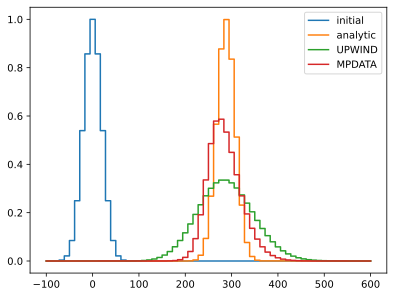

In [8]:
plot(
    x=x,
    initial=psi_0(x),
    analytic=psi_0(x - U * T_MAX),
    UPWIND=solve_upwind(nt=nt, C=np.full(nx - 1, U * dt / dx), psi=psi_0(x)),
    MPDATA=solve_mpdata(nt=nt, C=np.full(nx - 1, U * dt / dx), psi=psi_0(x))
)